In [29]:
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Definiowanie ścieżki do danych
data_path = "../../Datasets/lightning_photos/dataset"
data_dir = pathlib.Path(data_path)

In [31]:
# Definiowanie podstawowych parametrów
batch_size = 32
img_height = 224
img_width = 224

In [32]:
# Wyświetlanie ilości zdjęć w bazie (w bazie znajdują się tylko pliki .jpg i .jpeg)
jpg_count = len(list(data_dir.glob('*/*.jpg')))
jpeg_count = len(list(data_dir.glob('*/*.jpeg')))
print(jpg_count + jpeg_count)

3500


In [33]:
# Podział danych na część treningową i walidacyją
# Część treningowa
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,  # Ustalony seed dla powtarzalności wyników
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset ="training",
    validation_split=0.2,  # 0.8 dane testowe | 0.2 dane validacyjne
    label_mode='binary'  # 2 klasy
)

Found 3500 files belonging to 2 classes.
Using 2800 files for training.


In [34]:
# Część walidacyjna
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,  
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset ="validation",
    validation_split=0.2,
    label_mode='binary'
)

Found 3500 files belonging to 2 classes.
Using 700 files for validation.


In [35]:
# Wyświetlanie nazw klas
class_names = train_ds.class_names
print(class_names)

['lightning', 'no_lightning']


In [36]:
# Przyspieszanie ładowania danych
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
# Normalizacja danych (przedział [0,1])
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [38]:
# Wzbogacenie danych (data augmentation)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

def prepare_for_training(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds, augment=True)

In [39]:
# Sprawdzenie struktury danych
total_train = len(list(train_ds))
print(f"Total batches in training set: {total_train}")

Total batches in training set: 88


In [40]:
# Tworzenie modelu CNN
model = Sequential([
    layers.InputLayer(shape=(img_height, img_width, 3)),
    
    # Bloki konwolucyjne
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    # Warstwy gęste
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Wyjście dla klasyfikacji binarnej
])

In [41]:
# Kompilowanie modelu
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Trenowanie modelu
epochs=60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60


88/88 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6677 - loss: 25.2832 - val_accuracy: 0.7443 - val_loss: 0.4790
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.8391 - loss: 0.3667 - val_accuracy: 0.8714 - val_loss: 0.3097
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8753 - loss: 0.3003 - val_accuracy: 0.8571 - val_loss: 0.3367
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8712 - loss: 0.3158 - val_accuracy: 0.8686 - val_loss: 0.3169
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8965 - loss: 0.2808 - val_accuracy: 0.8786 - val_loss: 0.3339
Epoch 6/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8877 - loss: 0.3079 - val_accuracy: 0.8514 - val_loss: 0.3546
Epoch 7/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8817 - loss: 0.2932 - val_accuracy: 0.9057 - val_loss: 0.2536
Epoch 8/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8974 - loss: 0.2577 - val_accuracy: 0.9271 - val_loss: 0

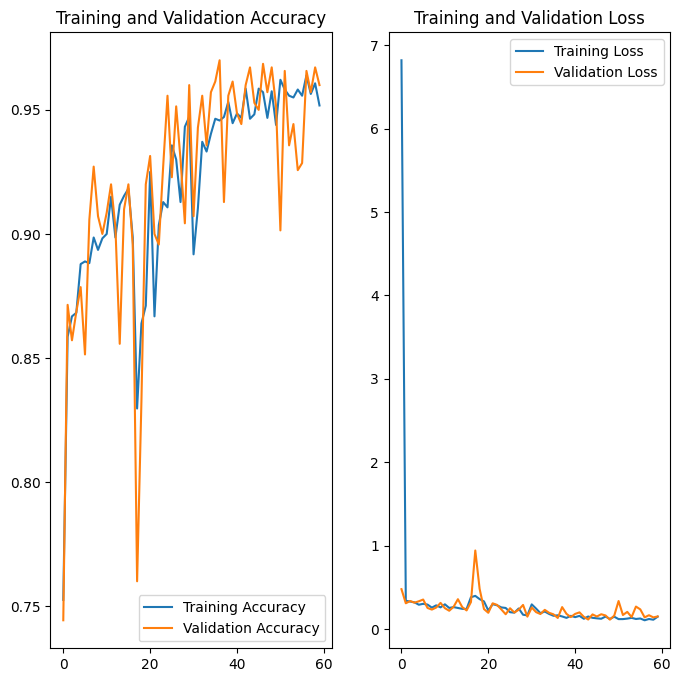

In [44]:
# Wyświetlenie dokładności i straty dla danych treningowych oraz walidacyjnych
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


<Figure size 1000x800 with 0 Axes>

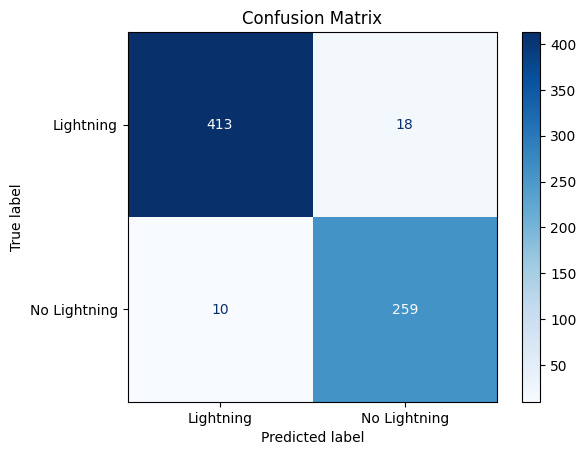

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predykcja na zbiorze walidacyjnym
y_true = []
y_pred = []
for images, labels in val_ds:
    predictions = model.predict(images)
    y_pred.extend(predictions.flatten())
    y_true.extend(labels.numpy())

# Konwersja predykcji na klasy binarne
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Wyświetlanie macierzy konfuzji
cm = confusion_matrix(y_true, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Lightning', 'No Lightning'])

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [46]:
from sklearn.metrics import classification_report

# Generowanie raportu klasyfikacji
report = classification_report(y_true, y_pred_binary, target_names=['Lightning', 'No_Lightning'])
print(report)

              precision    recall  f1-score   support

   Lightning       0.98      0.96      0.97       431
No_Lightning       0.94      0.96      0.95       269

    accuracy                           0.96       700
   macro avg       0.96      0.96      0.96       700
weighted avg       0.96      0.96      0.96       700



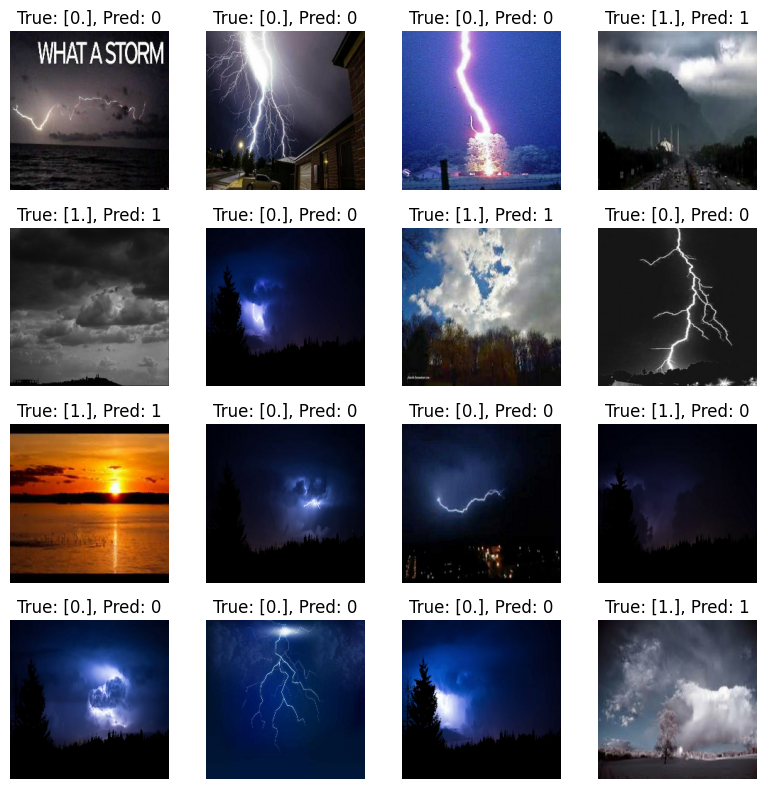

In [ ]:
# Losowe próbki do wyświetlenia 
examples = list(val_ds.as_numpy_iterator())
images, labels = zip(*examples)
images = np.concatenate(images)
labels = np.concatenate(labels)

indices = np.random.choice(len(images), size=16, replace=False)

# Wyświetlanie przykładowych obrazów z wartością prawdziwą i przewidywaną przez model
plt.figure(figsize=(8, 8))
for i, idx in enumerate(indices):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[idx].astype("uint8"))  
    plt.title(f"True: {labels[idx]}, Pred: {y_pred_binary[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

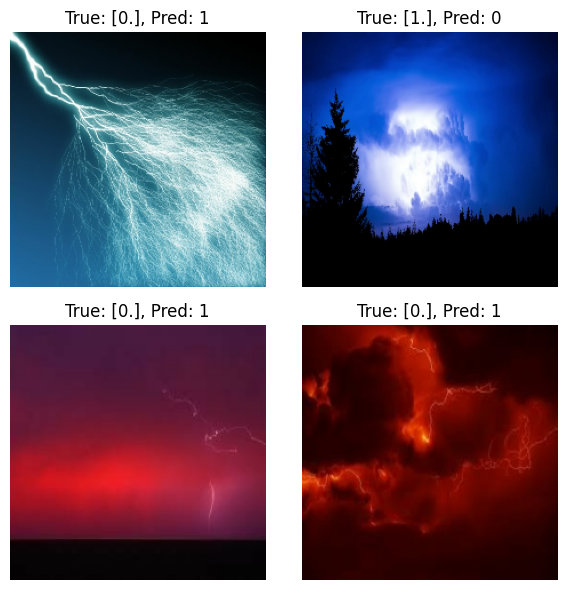

In [69]:
# Indeksy błędnych predykcji
errors = [i for i, (true, pred) in enumerate(zip(y_true, y_pred_binary)) if true != pred]

# Wyświetlanie przykładów błędnych klasyfikacji 
plt.figure(figsize=(6, 6))
for i, idx in enumerate(errors[:4]):  # Wyświetlanie pierwszych 4 przykładów
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[idx].astype("uint8"))  
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_binary[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [70]:
# Predykcja modelu dla przykładowego obrazu z dysku lokalnego

local_image_path = 'test_frame_lightning.jpg'

img = tf.keras.utils.load_img(
    local_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Stworzenie batcha

prediction = model.predict(img_array)
if prediction[0] < 0.5:
    print(f"Predykcja: Lightning ({1 - prediction[0][0]:.2f})")
else:
    print(f"Predykcja: No Lightning ({prediction[0][0]:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Predykcja: Lightning (0.99)


In [48]:
# Zapis modelu
model_name = "model_super_60_v3"
model.save(f"../../Models/{model_name}.keras")  